# Kr83m First Analysis

Data : Nov 2016 

Pax version : 6.5.0

In [12]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from multihist import Histdd

In [2]:
%matplotlib inline

In [3]:
matplotlib.rc('font', size=16)                   # Use big fonts...
plt.rcParams['figure.figsize'] = (12.0, 10.0)    # ... and big plots

In [4]:
from pax.configuration import load_configuration
pax_config = load_configuration('XENON1T')

In [5]:
n_channels = pax_config['DEFAULT']['n_channels']
pmts = pax_config['DEFAULT']['pmts']
tpc_height = pax_config['DEFAULT']['tpc_length']
tpc_radius = pax_config['DEFAULT']['tpc_radius']
gains = pax_config['DEFAULT']['gains']
busy_on_ch = pax_config['DEFAULT']['channels_in_detector']['busy_on'][0]

In [6]:
# Initialize hax
import hax

hax.__version__
hax.init(raw_data_access_mode='local',
         raw_data_local_path='/project/lgrandi/xenon1t/raw',
         minitree_paths = ['/home/masbou/scratch-midway/minitrees/pax_v6.5.0'])

In [7]:
dataset=[4580+ i for i in range(12)]

In [8]:
dataset2=[4608+i for i in range(6)]

In [9]:
dataset3=[4593+i for i in range(16)]

In [13]:
data= hax.minitrees.load(dataset + dataset2 + dataset3, treemakers=['Basics','DoubleScatter'])

/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/pandas/computation/align.py:98: RuntimeWarning: divide by zero encountered in log10
  ordm = np.log10(abs(reindexer_size - term_axis_size))


In [11]:
print('Total number of events = ', len(data))

Total number of events =  3252625


## Double Scatter TreeMaker

For this analysis, we need : 
- Main S1 (PE)= s1_a (32.2 keV)
- Second main S1 (PE)= s1_b (9.4 keV)
- Delay Time (ns)= s1_b_center_time-s1_a_center_time
- Number of PMTs contributing to main S1 = s1_b_n_contributing_channels
- Number of PMTs contributing to s1_b distinct from the PMTs that contributed to s1_a = ds_s1_b_n_distinct_channels

So, we use the double scattered treemaker which : 

- Search for a interaction (giving S1_0 and S2_0)
- Search for other interaction (giving S1_1 and S2_1)
- Order in times the scatters (giving S1_a for the 1st S1 and S1_b for the 2nd)
- Find the largest hits in each channel,  S1_a and S1_b and determine peaks and interactions information (Peak and Interaction Output)

Peak Output (for PEAK in [s1_a, s2_a, s1_b, s2_b, s1_2, s2_2])
- PEAK : The uncorrected area in pe of the peak
- PEAK_area_fraction_top : The fraction of uncorrected area in the peak seen by the top array
- PEAK_center_time : The center_time in ns of the peak

- PEAK_n_contributing_channels : The number of PMTs contributing to the peak
- PEAK_range_50p_area : The width of the peak (ns), duration of region that contains 50% of the area of the peak

Interaction Output (for INT in [int_a, int_b])
- INT_x : The x-position of this interaction (primary algorithm chosen by pax, currently TopPatternFit)
- INT_y : The y-position of this interaction
- INT_z : The z-position of this interaction
- INT_s1_area_correction : The multiplicative s1 area correction of this interaction
- INT_s2_area_correction : The multiplicative s2 area correction of this interaction
- INT_drift_time : The drift time in ns (pax units) of this interaction
- INT_s1_pattern_fit : The s1 pattern fit (-log liklihood) of this interaction

DoubleScatter Specific Output
- ds_s1_b_n_distinct_channels : number of PMTs contributing to s1_b distinct from the PMTs that contributed to s1_a
- ds_second_s2 : True if selected interactions have distinct s2s


In [138]:
hax.misc.code_hider()

In [360]:
data_good=data[(data['s1_a']>0)&(data['s1_b']>0)]
#print(len(data_good))

In [361]:
dat=data_good

In [362]:
dfs=[]
lens=[]
# immediately apply full TPC fiducial cut, also removes NANs
dfs.append( dat[ (dat['int_a_z'] <= 0.0) & (dat['int_a_z'] >= -tpc_height)
             & (dat['int_a_x']**2 + dat['int_a_y']**2 <= tpc_radius**2)
             & (dat['int_b_z'] <= 0.0) & (dat['int_b_z'] >= -tpc_height)
             & (dat['int_b_x']**2 + dat['int_b_y']**2 <= tpc_radius**2)] )
lens.append(len(dat))
del dat

In [363]:
#Definition of Delay Time
for df in dfs:
    df['s1_dt_center_time'] = df['s1_b_center_time'] - df['s1_a_center_time']
df.head()

/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,cs1,cs2,drift_time,ds_s1_b_n_distinct_channels,ds_second_s2,event_number,int_a_drift_time,int_a_s1_area_correction,int_a_s1_pattern_fit,int_a_s2_area_correction,...,s2_b_center_time,s2_b_n_contributing_channels,s2_b_range_50p_area,s2_range_50p_area,x,y,z,cs1_a,cs1_b,s1_dt_center_time
6,5133.015880,9.216327e+05,235500.0,0.0,NaN,6,235500.0,1.148806,1810.497803,1.738784,...,7.267401e+05,213.0,1002.039080,2574.522024,30.975555,23.210606,-33.880432,5133.015880,10.915545,4.687244e+04
58,6514.195681,1.689620e+06,535710.0,0.0,NaN,58,535710.0,0.849598,3106.495850,3.519696,...,1.060765e+06,209.0,11263.315847,1821.905289,-38.984310,4.119272,-76.826378,6514.195681,6.939374,4.593498e+05
128,2400.340877,7.560542e+05,3670.0,13.0,NaN,128,3670.0,1.427428,1455.106934,1.008658,...,1.239883e+06,213.0,332.954519,290.013175,39.279694,-3.615917,-0.331091,2400.340877,1112.117169,7.329033e+05
175,6868.319346,1.021566e+06,97630.0,2.0,NaN,175,97630.0,1.351166,2162.644775,1.257759,...,2.428847e+06,213.0,290.075525,744.535622,-1.648493,35.377884,-14.050893,6868.319346,2636.157205,1.922181e+06
297,6544.341420,1.564957e+06,360860.0,0.0,NaN,297,360860.0,1.001483,2547.525391,2.334166,...,8.935279e+05,213.0,1613.695683,1316.956293,23.972553,-0.872867,-51.856117,6544.341420,22.677876,8.915297e+04


# Shape of the data with no cut

In [364]:
df['cs1_a'] =df['s1_a'] * df['int_a_s1_area_correction']
df['cs1_b'] =df['s1_b'] * df['int_b_s1_area_correction']
df['cs2_a'] =df['s2_a'] * df['int_a_s2_area_correction']

df.head()

/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

,cs1,cs2,drift_time,ds_s1_b_n_distinct_channels,ds_second_s2,event_number,int_a_drift_time,int_a_s1_area_correction,int_a_s1_pattern_fit,int_a_s2_area_correction,...,s2_b_n_contributing_channels,s2_b_range_50p_area,s2_range_50p_area,x,y,z,cs1_a,cs1_b,s1_dt_center_time,cs2_a
6,5133.015880,9.216327e+05,235500.0,0.0,NaN,6,235500.0,1.148806,1810.497803,1.738784,...,213.0,1002.039080,2574.522024,30.975555,23.210606,-33.880432,5133.015880,10.915545,4.687244e+04,9.216327e+05
58,6514.195681,1.689620e+06,535710.0,0.0,NaN,58,535710.0,0.849598,3106.495850,3.519696,...,209.0,11263.315847,1821.905289,-38.984310,4.119272,-76.826378,6514.195681,6.939374,4.593498e+05,1.689620e+06
128,2400.340877,7.560542e+05,3670.0,13.0,NaN,128,3670.0,1.427428,1455.106934,1.008658,...,213.0,332.954519,290.013175,39.279694,-3.615917,-0.331091,2400.340877,1112.117169,7.329033e+05,7.560542e+05
175,6868.319346,1.021566e+06,97630.0,2.0,NaN,175,97630.0,1.351166,2162.644775,1.257759,...,213.0,290.075525,744.535622,-1.648493,35.377884,-14.050893,6868.319346,2636.157205,1.922181e+06,1.021566e+06
297,6544.341420,1.564957e+06,360860.0,0.0,NaN,297,360860.0,1.001483,2547.525391,2.334166,...,213.0,1613.695683,1316.956293,23.972553,-0.872867,-51.856117,6544.341420,22.677876,8.915297e+04,1.564957e+06


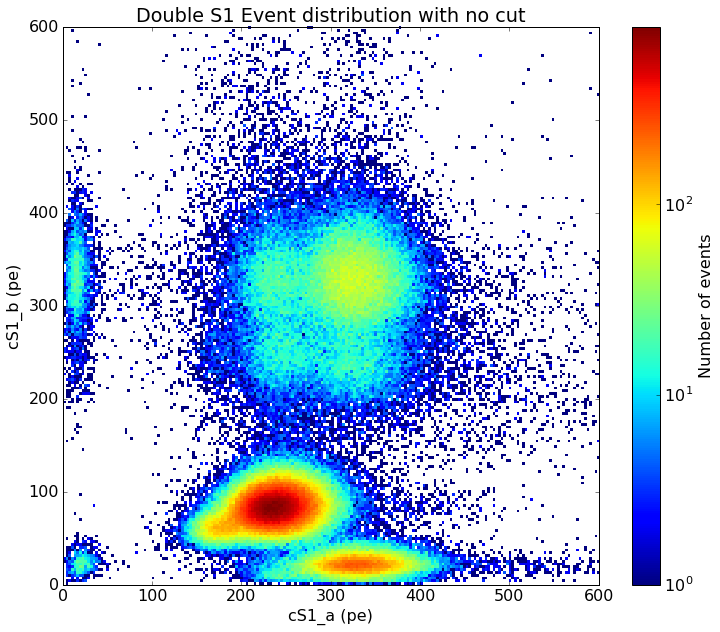

In [365]:
plt.plot()
plt.hist2d(df['cs1_a'],
            df['cs1_b'], 
            range=[[0,600],[0,600]],
            bins=[200,200], norm=matplotlib.colors.LogNorm())

plt.colorbar(label='Number of events')
plt.xlabel('cS1_a (pe)')
plt.ylabel('cS1_b (pe)')
plt.title('Double S1 Event distribution with no cut')
plt.savefig('Double S1 Event distribution with no cut.png')
plt.show()

# Cut apply

Delay Time between the two signals : [600 - 2000] ns 

Number of PMTs contributing to second S1 distinct from the PMTs that contributed to the first S1 > 3

Fiducial Volume (0< r$^2$ <1000 cm$^2$ and -80< z <-20 cm)

In [17]:
#Selectin on delay time
df_dt_cut = df[(df['s1_dt_center_time']>600) & (df['s1_dt_center_time']<2000)]
print (len(df_dt_cut))

NameError: name 'df' is not defined

In [367]:
#Selection on contributing channels
df_ch_cut=df_dt_cut[df_dt_cut['ds_s1_b_n_distinct_channels']>3]
#print(len(df_dt_cut))

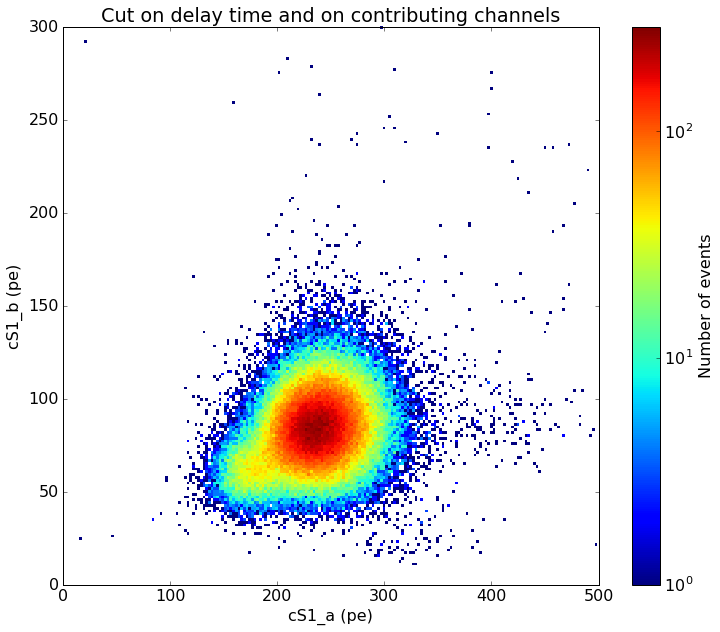

In [368]:
plt.plot()
plt.hist2d(df_ch_cut['cs1_a'],
            df_ch_cut['cs1_b'], 
            range=[[0,500],[0,300]],
            bins=[200,200], norm=matplotlib.colors.LogNorm())

plt.colorbar(label='Number of events')
plt.xlabel('cS1_a (pe)')
plt.ylabel('cS1_b (pe)')
plt.title('Cut on delay time and on contributing channels')
plt.show()

In [369]:
#Cut on the fiducial volume
df_fv_cut=df_ch_cut[(df_ch_cut['int_a_z'] <= -20) & (df_ch_cut['int_a_z'] >= -80)
             & (df_ch_cut['int_a_x']**2 + df_ch_cut['int_a_y']**2 <= 1000)
             & (df_ch_cut['int_b_z'] <= -20) & (df_ch_cut['int_b_z'] >= -80)
             & (df_ch_cut['int_b_x']**2 + df_ch_cut['int_b_y']**2 <= 1000 )]
#print(len(df_fv_cut))
df2=df_fv_cut

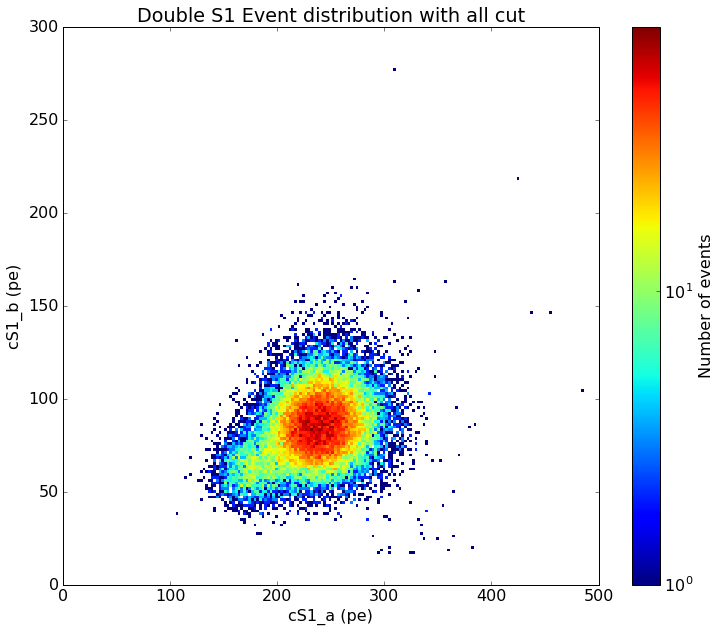

In [404]:
plt.plot()
plt.hist2d(df_fv_cut['cs1_a'],
            df_fv_cut['cs1_b'], 
            range=[[0,500],[0,300]],
            bins=[200,200], norm=matplotlib.colors.LogNorm())

plt.colorbar(label='Number of events')
plt.xlabel('cS1_a (pe)')
plt.ylabel('cS1_b (pe)')
plt.title('Double S1 Event distribution with all cut')
plt.show()

In [371]:
# plt.subplot(211)

# plt.scatter(df2['int_a_x'],df2['int_a_y'], c=df2['s1_a'],
#             edgecolor='none', marker='.', s=50, vmin=100, vmax=400 )
# plt.xlabel('x(cm)')
# plt.ylabel('y(cm)')
# plt.xlim(-50,50)
# plt.ylim(-50,50)
# plt.colorbar(label='S1_a')
# theta = np.linspace(0, 2*np.pi, 100)

# x = 50*np.cos(theta)
# y = 50*np.sin(theta)
# plt.axis('equal')
# plt.plot(x, y)
# plt.title('S1_a')

# plt.subplot(212)

# plt.scatter(df2['int_b_x'],df2['int_b_y'], c=df2['s1_b'],
#             edgecolor='none', marker='.', s=50, vmin=50, vmax=150 )
# plt.xlabel('x(cm)')
# plt.ylabel('y(cm)')

# plt.xlim(-50,50)
# plt.ylim(-50,50)
# plt.colorbar(label='S1_b')
# theta = np.linspace(0, 2*np.pi, 100)

# x = 50*np.cos(theta)
# y = 50*np.sin(theta)
# plt.plot(x, y)
# plt.title('S1_b')
# plt.axis('equal')
# plt.show()


In [372]:
print('The total number of events left after all the cut applied is ', len(df2))

The total number of events left after all the cut applied is  41070


# S1s as a function of delay time

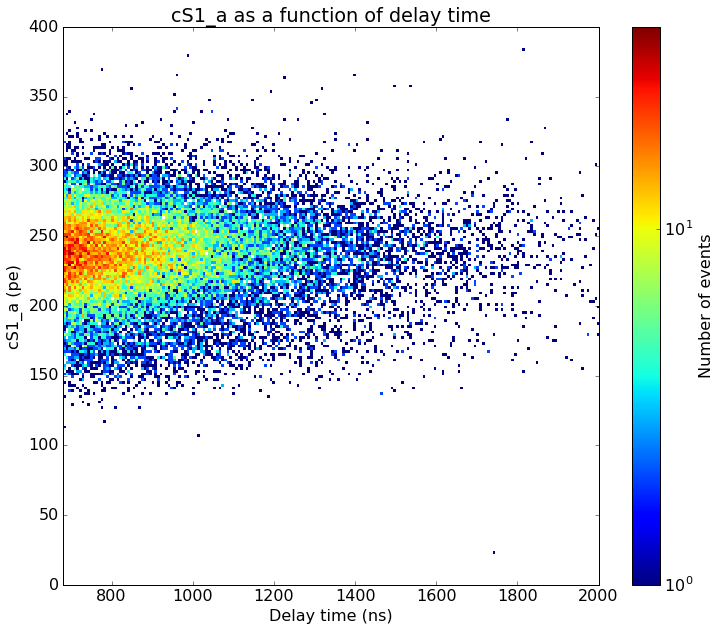

In [373]:
plt.plot()
plt.hist2d(df2['s1_dt_center_time'],
            df2['cs1_a'], 
            range=[[680,2000],[0,400]],
            bins=[200,200], norm=matplotlib.colors.LogNorm())

plt.colorbar(label='Number of events')
plt.xlabel('Delay time (ns)')
plt.ylabel('cS1_a (pe)')
plt.title ('cS1_a as a function of delay time')
plt.show()


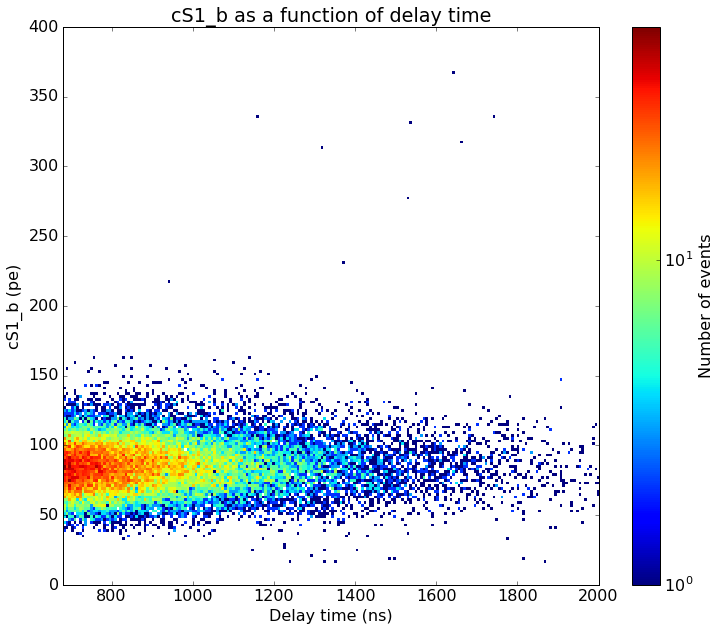

In [374]:
plt.plot(122)
plt.hist2d(df2['s1_dt_center_time'],
            df2['cs1_b'], 
            range=[[680,2000],[0,400]],
            bins=[200,200], norm=matplotlib.colors.LogNorm())

plt.colorbar(label='Number of events')
plt.xlabel('Delay time (ns)')
plt.ylabel('cS1_b (pe)')
plt.title('cS1_b as a function of delay time')
plt.show()


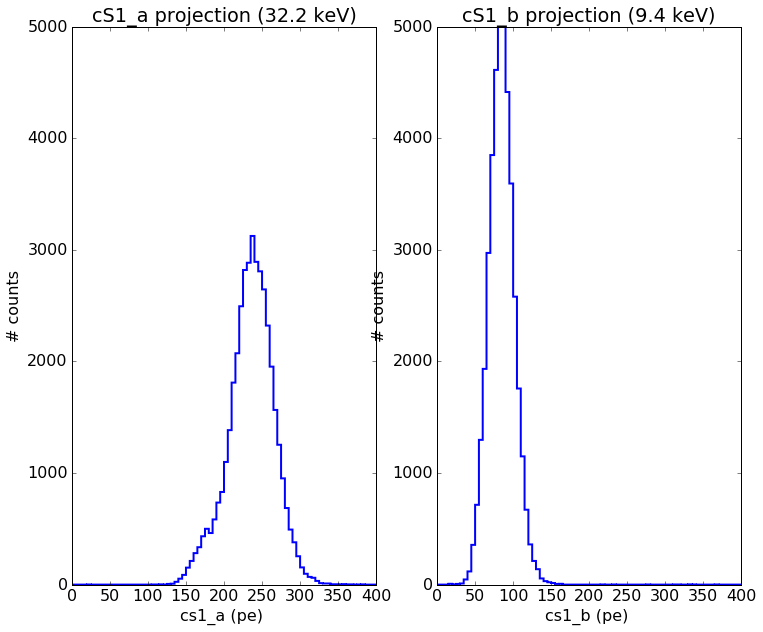

In [375]:
plt.subplot(121)
plt.hist(df2['cs1_a'], bins = 80, range = (0,400),histtype='step',lw=2)
plt.ylabel('# counts')
plt.xlabel('cs1_a (pe) ')
plt.ylim(0,5000)
plt.title('cS1_a projection (32.2 keV)')

plt.subplot(122)
plt.hist(df2['cs1_b'], bins = 80, range = (0,400),histtype='step',lw=2)
plt.ylabel('# counts')
plt.xlabel('cs1_b (pe) ')
plt.ylim(0,5000)
plt.title('cS1_b projection (9.4 keV)')
plt.show()

In [376]:
#Gaussian Fit 

In [377]:
# #from recarray_tools import filter_on_fields, group_by, append_fields
# from tqdm import tqdm
# from scipy.optimize import curve_fit
# from pax.formats import flat_data_formats
# file_format = 'hdf5'
# ioformat = flat_data_formats[file_format]()

In [378]:
# # Settings!
# binsize_a = 50
# myrange_a=(150,350)
# mybins_a=50
# # This is the function to fit
# def gauss(x, *p):
#     A, mu, sigma = p
#     return A*np.exp(-(x-mu)**2/(2.*sigma**2))

# # p is the initial guess

# S1_a_hist = plt.hist(df2['s1_a'],bins=mybins_a,
#          histtype='step',label='S1_a',range=myrange_a,lw=2, color='red')


# plt.xlabel("S1_a (pe)")
# plt.ylabel("counts ")

# hist_counts_a,hist_energy_a,_=S1_a_hist

# # Transform bin EDGES to bin CENTERS (decreases size by one)
# x_fit_1d_a =[(hist_energy_a[i+1]+hist_energy_a[i])/2
#            for i in range(0,len(hist_energy_a)-1)]

# x_flat_a = []
# y_flat_a = []


# #  Loop over all combinations of x and y coordinates and add x, y and z into one n x n list each
# #  Has been checked.

# for i_x in range(len(x_fit_1d_a)):
#     x_flat_a.append(x_fit_1d_a[i_x])
#     y_flat_a.append(hist_counts_a[i_x])
        
# #  oneD_Gaussian:

# initial_guess_a = (400,250,50)

# popt_a, pcov_a = curve_fit(gauss,x_flat_a, y_flat_a, p0=initial_guess_a)
# perr_a = np.sqrt(np.diag(pcov_a))

# #  For plotting purposes
# data_fitted = np.array([gauss(x, *popt_a)
#                for x in x_fit_1d_a]).flatten()


# plt.plot(x_fit_1d_a, data_fitted.reshape(binsize_a,order ='F'))

# plt.show()

# print('Amplitude = ', popt_a[0])
# print('Mean = ', popt_a[1])
# print('sigma = ', popt_a[2])
# print('Energy Resolution = ',popt_a[2]/popt_a[1]*100, ' %' )

In [379]:
# # Settings!
# binsize_b = 50
# myrange_b=(50,150)
# mybins_b=50
# # This is the function to fit
# def gauss(x, *p):
#     A, mu, sigma = p
#     return A*np.exp(-(x-mu)**2/(2.*sigma**2))

# # p is the initial guess

# S1_b_hist = plt.hist(df2['s1_b'],bins=mybins_b,
#          histtype='step',label='S1_b',range=myrange_b,lw=2, color='red')


# plt.xlabel("S1_b (pe)")
# plt.ylabel("counts ")

# hist_counts_b,hist_energy_b,_=S1_b_hist

# # Transform bin EDGES to bin CENTERS (decreases size by one)
# x_fit_1d_b =[(hist_energy_b[i+1]+hist_energy_b[i])/2
#            for i in range(0,len(hist_energy_b)-1)]

# x_flat_b = []
# y_flat_b = []


# #  Loop over all combinations of x and y coordinates and add x, y and z into one n x n list each
# #  Has been checked.

# for i_x in range(len(x_fit_1d_b)):
#     x_flat_b.append(x_fit_1d_b[i_x])
#     y_flat_b.append(hist_counts_b[i_x])
        
# #  oneD_Gaussian:

# initial_guess_b = (800,90,20)

# popt_b, pcov_b = curve_fit(gauss,x_flat_b, y_flat_b, p0=initial_guess_b)
# perr_b = np.sqrt(np.diag(pcov_b))

# #  For plotting purposes
# data_fitted = np.array([gauss(x, *popt_b)
#                for x in x_fit_1d_b]).flatten()


# plt.plot(x_fit_1d_b, data_fitted.reshape(binsize_b,order ='F'))

# plt.show()

# print('Amplitude = ', popt_b[0])
# print('Mean = ', popt_b[1])
# print('sigma = ', popt_b[2])
# print('Energy Resolution = ',popt_b[2]/popt_b[1]*100, ' %' )

# 1st method to extract light yield (better one at the end of this notebook)

Method : 
- Extract the mean values of S1_a and S1_b for each slices of delay time (Slices of 60 ns)
- Divide the mean values of S1_a and S1_b by the corresponding energy
- Fit the mean values with a linear function (ax + b, b is the light yield)

In [380]:
# Mean S1 values 
# Mean = popt_a[1]
s1_a_means=[]
dt_slices_a=[]
number_list=[]
dt_slices_a=np.arange(600,2100,60)

dt_plot=[]

for i,dt in enumerate(dt_slices_a):
    box_a=((df2['s1_dt_center_time']>dt_slices_a[i]) & (df2['s1_dt_center_time']<dt_slices_a[i+1])) 
    
    if len(df2[box_a])==0: 
        print('error, the box don t contain any event, increase the slice side')
        break
            
    else :
        s1_a_means.append((np.sum(df2[box_a]['cs1_a']))/len(df2[box_a])/32.2)
    
    dt_plot.append((dt_slices_a[i]+dt_slices_a[i+1])/2)
    
    if i==(len(dt_slices_a)-2):
        break
        
s1_a_means=np.array(s1_a_means)
dt_plot= np.array(dt_plot)
s1_a_means=s1_a_means.reshape(len(dt_slices_a)-1)
s1_a_means_plot=dt_plot,s1_a_means

In [381]:
# Mean S1 values 
# Mean = popt_b[1]
s1_b_means=[]
dt_slices_b=[]
number_list=[]
dt_slices_b=np.arange(600,2100,60)

dt_plot=[]

for i,dt in enumerate(dt_slices_b):
    box_b=((df2['s1_dt_center_time']>dt_slices_b[i]) & (df2['s1_dt_center_time']<dt_slices_b[i+1])) 
    
    if len(df2[box_b])==0: 
        print('error, the box don t contain any event, increase the slice side')
        break
            
    else :
        s1_b_means.append((np.sum(df2[box_b]['cs1_b']))/len(df2[box_b])/9.4)
    
    dt_plot.append((dt_slices_b[i]+dt_slices_b[i+1])/2)
    
    if i==(len(dt_slices_b)-2):
        break
        
s1_b_means=np.array(s1_b_means)
dt_plot= np.array(dt_plot)
s1_b_means=s1_b_means.reshape(len(dt_slices_b)-1)
s1_b_means_plot=dt_plot,s1_b_means

/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


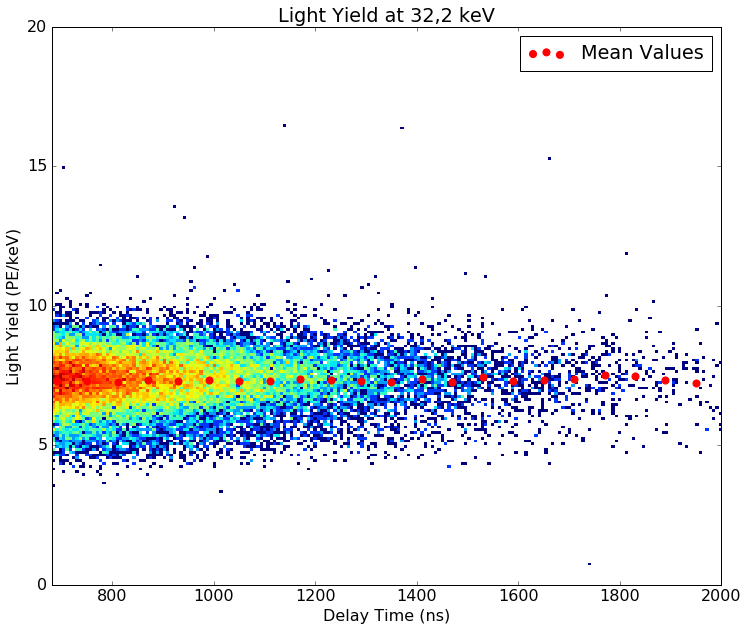

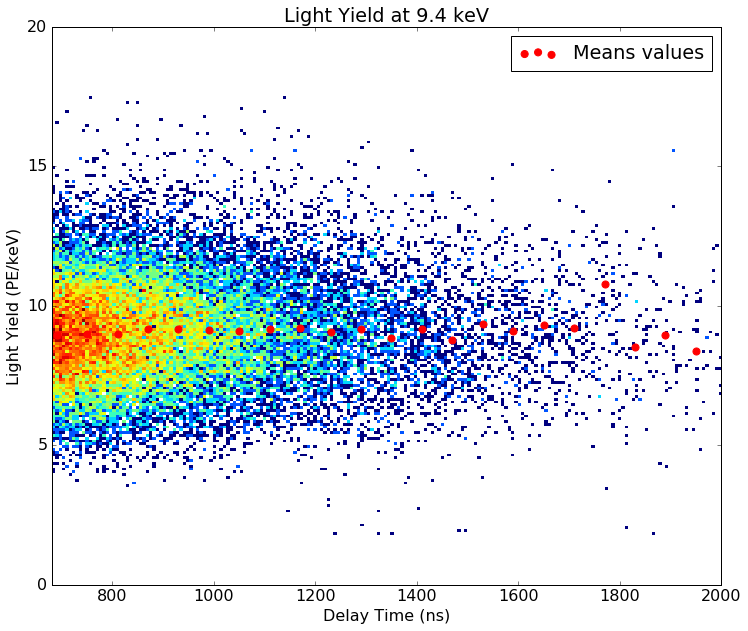

In [382]:
fig_a, ax_a = plt.subplots()
ax_a.hist2d(df2['s1_dt_center_time'],
            df2['cs1_a']/32.2, 
            range=[[680,2000],[0,20]],
            bins=[200,200], norm=matplotlib.colors.LogNorm())
ax_a.scatter(s1_a_means_plot[0],
            s1_a_means_plot[1], color='r', s=50, label="Mean Values")



ax_a.set_xlabel ('Delay Time (ns)')
ax_a.set_ylabel ('Light Yield (PE/keV)')
ax_a.set_title('Light Yield at 32,2 keV')
ax_a.legend()
fig_a.show()

fig_b, ax_b = plt.subplots()

ax_b.scatter(s1_b_means_plot[0],
            s1_b_means_plot[1], color='r', s=50, label="Means values")

ax_b.hist2d(df2['s1_dt_center_time'],
            df2['cs1_b']/9.4, 
            range=[[680,2000],[0,20]],
            bins=[200,200], norm=matplotlib.colors.LogNorm())

ax_b.set_xlabel('Delay Time (ns)')
ax_b.set_ylabel('Light Yield (PE/keV)')
ax_b.set_title('Light Yield at 9.4 keV')
ax_b.legend()
fig_b.show()

/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


Light Yield at 32.2 keV  7.33058261813
Light Yield at 9.4 keV  9.03679315915


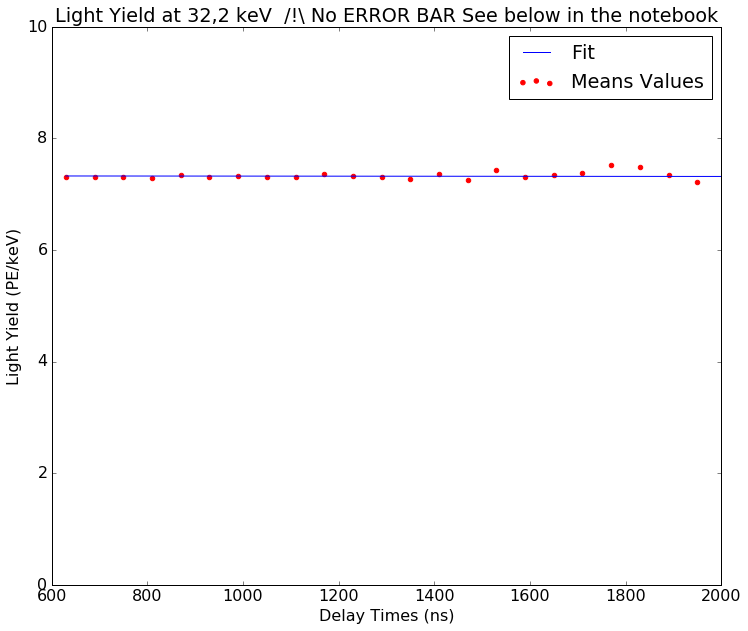

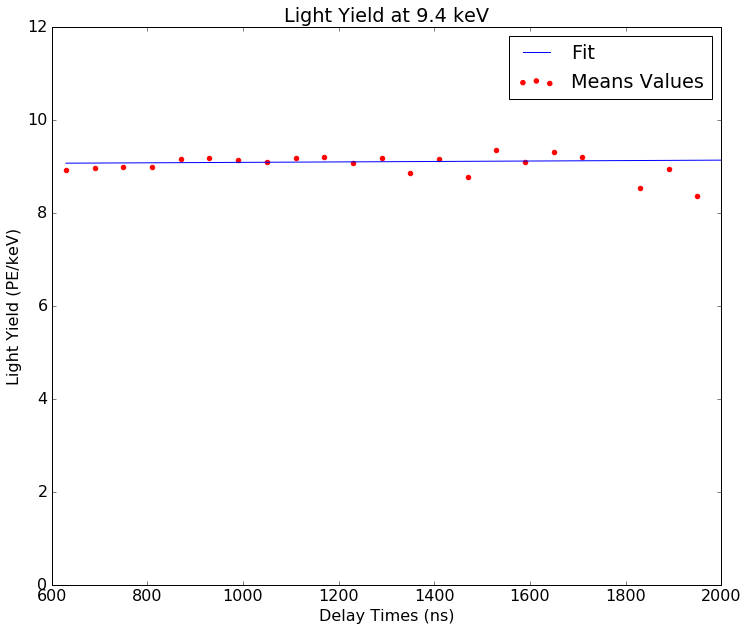

In [383]:
x= s1_a_means_plot[0]
y= s1_a_means_plot[1]

fig, ax = plt.subplots()
fit = np.polyfit(x, y, deg=1)
ax.plot(x, fit[0] * x + fit[1], color='blue', label="Fit")
ax.scatter(x, y,color='r', label='Means Values')
ax.set_ylim([0,10])
ax.set_xlim([600,2000])
ax.set_xlabel('Delay Times (ns)')
ax.set_ylabel('Light Yield (PE/keV)')
ax.legend()
ax.set_title('Light Yield at 32,2 keV  /!\ No ERROR BAR See below in the notebook')


xb= s1_b_means_plot[0]
yb= s1_b_means_plot[1]

figb, axb = plt.subplots()
fitb = np.polyfit(xb, yb, deg=1)
axb.plot(xb, fitb[0] * xb + fitb[1], color='blue', label="Fit")
axb.scatter(xb, yb, color='r', label='Means Values')
axb.set_ylim([0,12])
axb.set_xlim([600,2000])
axb.set_xlabel('Delay Times (ns)')
axb.set_ylabel('Light Yield (PE/keV)')

axb.set_title('Light Yield at 9.4 keV')
axb.legend()
fig.show()

print('Light Yield at 32.2 keV ', fit[1])
print('Light Yield at 9.4 keV ', fitb[1])

# 1st method to estimate the Electron Lifetime (EL)

Same method that for extract the Light Yield : 
- Extract the mean values of S2_a for each slices of drift time (Slices of 20 µs)
- Fit the log of the mean values with a linear function (ax + b, a =-1/EL)

Drift Time [ns]= int_a_drift_time 

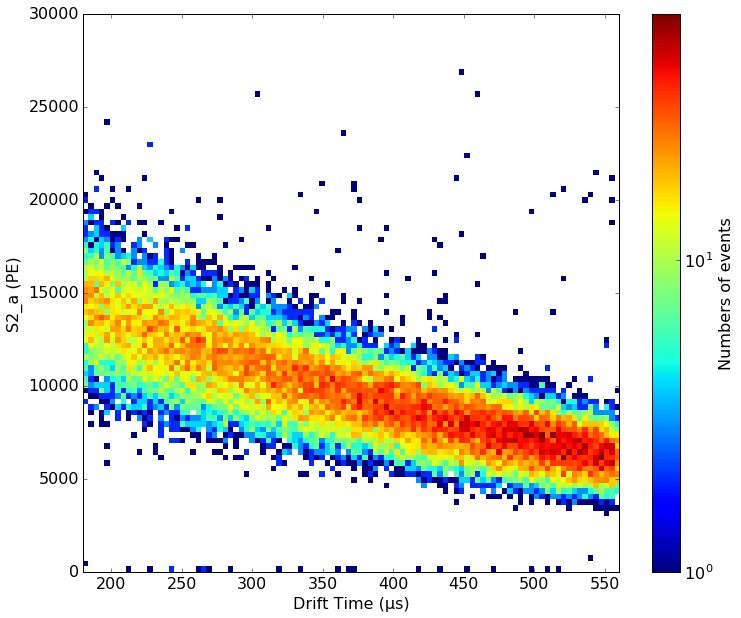

In [391]:
plt.plot()
plt.hist2d(df2['int_a_drift_time']/1000,
            df2['s2_a'], range=[[180,560],[0,30000]],
            bins=[100,100], norm=matplotlib.colors.LogNorm())
plt.colorbar(label='Numbers of events')
plt.xlabel('Drift Time (µs)')
plt.ylabel('S2_a (PE)')
plt.show()

In [392]:
# Mean S2 values 
# Mean = popt_a[1]
s2_a_means=[]
DT_slices_a=[]
number_list=[]
DT_slices_a=np.arange(200,580,20)

DT_plot=[]

for i,dt in enumerate(DT_slices_a):
    box2_a=((df2['int_a_drift_time']/1000>DT_slices_a[i]) & (df2['int_a_drift_time']/1000<DT_slices_a[i+1])) 
    
    if len(df2[box2_a])==0: 
        print('error, the box don t contain any event, increase the slice side')
        break
            
    else :
        s2_a_means.append((np.sum(df2[box2_a]['s2_a']))/len(df2[box2_a]))
    
    DT_plot.append((DT_slices_a[i]+DT_slices_a[i+1])/2)
    
    if i==(len(DT_slices_a)-2):
        break
        
s2_a_means=np.array(s2_a_means)
DT_plot= np.array(DT_plot)
s2_a_means=s2_a_means.reshape(len(DT_slices_a)-1)
s2_a_means_plot=DT_plot,s2_a_means

/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


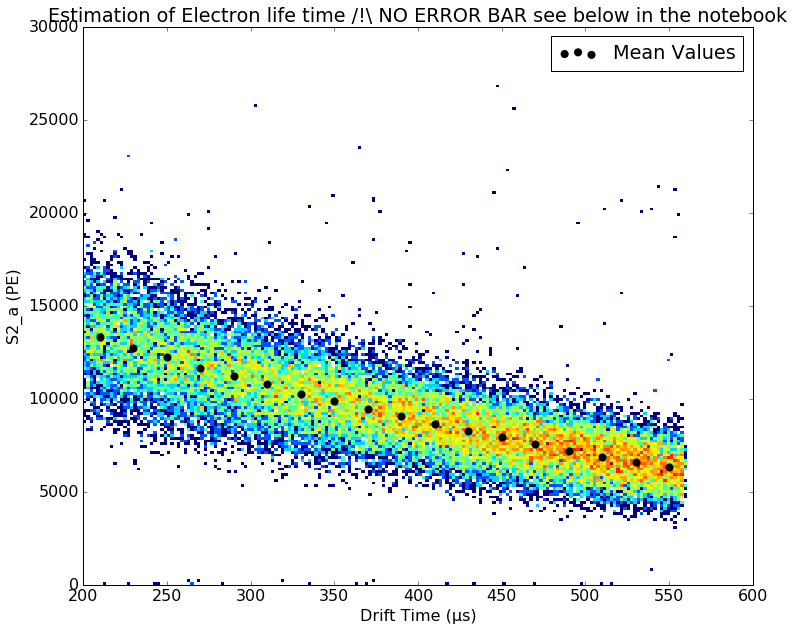

In [393]:
fig_a2, ax_a2 = plt.subplots()
ax_a2.hist2d(df2['int_a_drift_time']/1000,
            df2['s2_a'], 
            range=[[200,600],[0,30000]],
            bins=[200,200], norm=matplotlib.colors.LogNorm())

ax_a2.scatter(s2_a_means_plot[0],
            s2_a_means_plot[1], color='black', s=50, label="Mean Values")
ax_a2.set_xlabel ('Drift Time (µs)')
ax_a2.set_ylabel ('S2_a (PE)')
ax_a2.set_title('Estimation of Electron life time /!\ NO ERROR BAR see below in the notebook')
ax_a2.legend()
fig_a2.show()

/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


EL=  455.915033945 µs


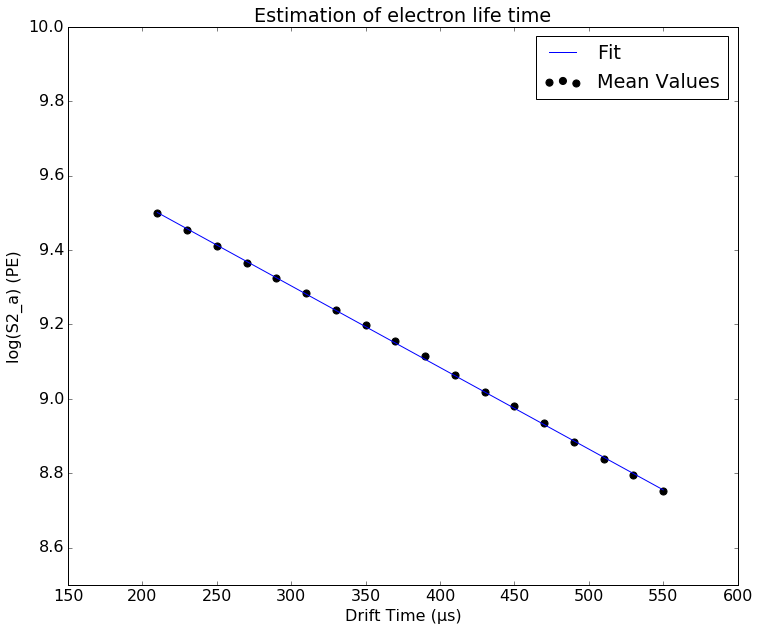

In [394]:
x= s2_a_means_plot[0]
y= np.log(s2_a_means_plot[1])

fig_a2, ax_a2 = plt.subplots()
fit = np.polyfit(x, y, deg=1)

ax_a2.plot(x, fit[0] * x + fit[1], color='blue', label="Fit")
ax_a2.scatter(s2_a_means_plot[0],
            np.log(s2_a_means_plot[1]), color='black', s=50, label="Mean Values")



ax_a2.set_xlabel ('Drift Time (µs)')
ax_a2.set_ylabel ('log(S2_a) (PE)')
ax_a2.set_title('Estimation of electron life time')
ax_a2.set_ylim([8.5,10])
ax_a2.set_xlim([150,600])

ax_a2.legend()
fig_a2.show()

print("EL= ", -1/(fit[0]), 'µs')



# 2nd Method to extract Light Yield and Electron Lifetime

Same thing that before but this time, we used python functions (np.average, np.bin_center ect...)

We can get the error bar !! 

error bar = standard deviation / sqrt(number of events)

## Light Yield

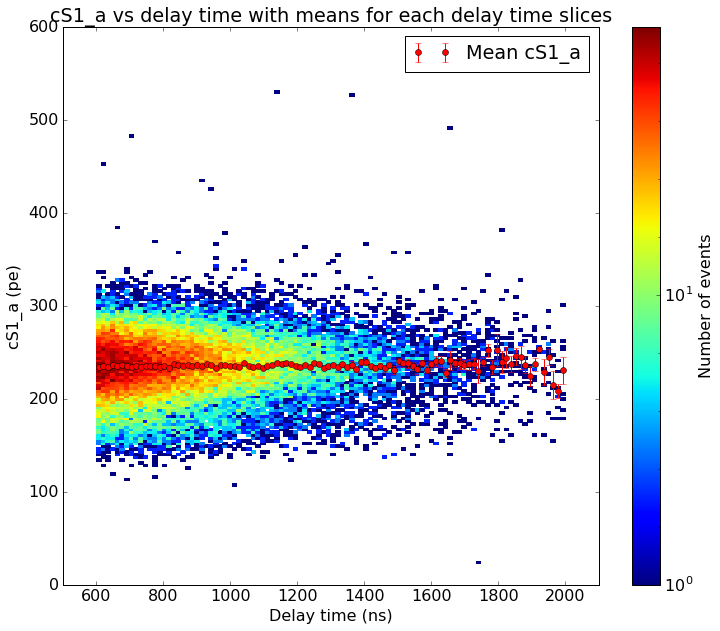

In [413]:
# Error bar : standard deviation / sqrt(N)

delay_time=df2['s1_dt_center_time']
cs1_a=df2['cs1_a']

h = Histdd(delay_time, cs1_a, bins=(100,200), #Mean calculate on each bins
           axis_names=['delay_time', 'cs1_a'])

t = h.bin_centers('delay_time') # t = delay time (bin) 
ms1_a = h.average('cs1_a').histogram # ms1_a = mean value of s1_a
std_error_a = (h.std(axis='cs1_a') / np.sqrt(h.sum('cs1_a'))).histogram # std : Compute the standard deviation along the specified axis

h.plot(log_scale=True, cblabel='Number of events')
plt.errorbar(t, ms1_a, yerr=std_error_a,
             marker='o', linestyle='', color='red',
             label='Mean cS1_a')
plt.xlabel('Delay time (ns)')
plt.ylabel('cS1_a (pe)')
plt.ylim(0,600)
plt.xlim(500,2100)
plt.legend()
plt.title("cS1_a vs delay time with means for each delay time slices")
plt.show()

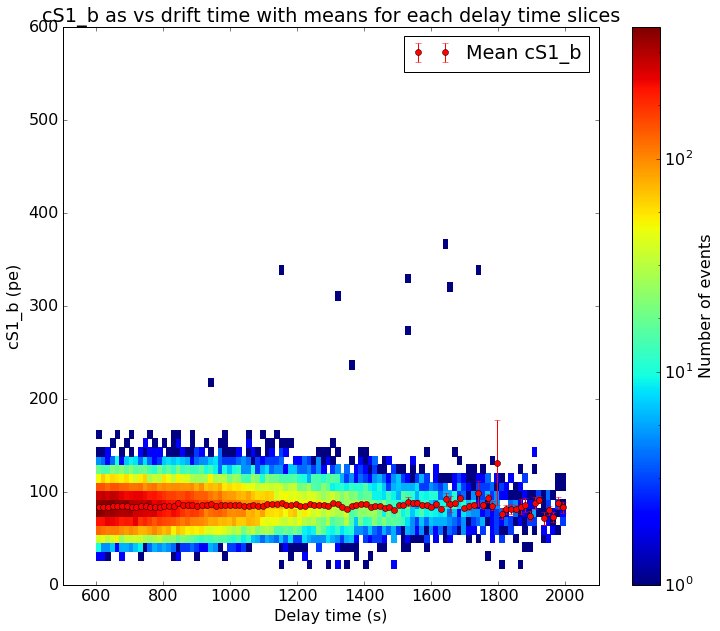

In [414]:
# Error bar : standard deviation / sqrt(N)

delay_time=df2['s1_dt_center_time']
cs1_b=df2['cs1_b']

h = Histdd(delay_time, cs1_b, bins=(100, 200), #Mean calculate on each bins
           axis_names=['delay_time', 'cs1_b'])

t = h.bin_centers('delay_time') # t = delay time (bin) 
ms1_b = h.average('cs1_b').histogram # ms1 = mean value of s1
std_error_b = (h.std(axis='cs1_b') / np.sqrt(h.sum('cs1_b'))).histogram # std : Compute the standard deviation along the specified axis

h.plot(log_scale=True, cblabel='Number of events')
plt.errorbar(t, ms1_b, yerr=std_error_b,
             marker='o', linestyle='', color='red',
             label='Mean cS1_b')
plt.xlabel('Delay time (s)')
plt.ylabel('cS1_b (pe)')
plt.ylim(0,600)
plt.xlim(500,2100)
plt.legend()
plt.title("cS1_b as vs drift time with means for each delay time slices")
plt.show()


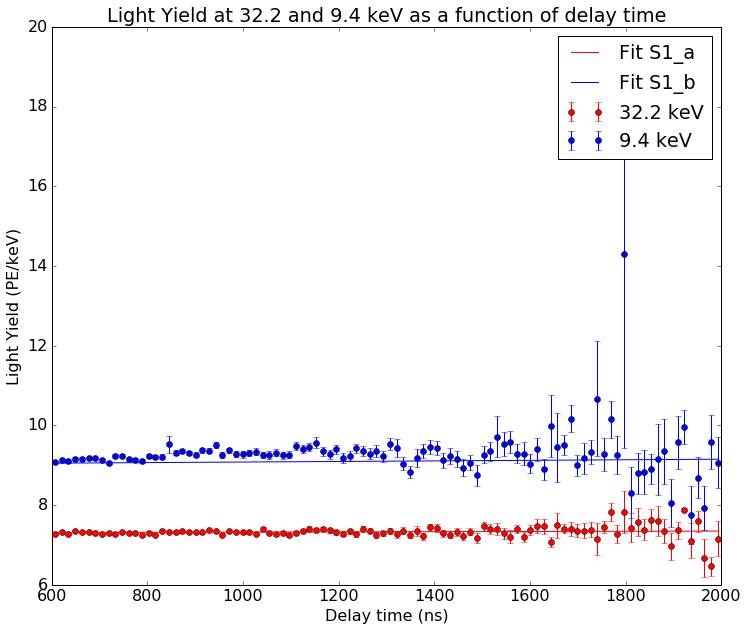

In [400]:
fit_a = np.polyfit(t, ms1_a/32.2, deg=1)
fit_b = np.polyfit(t, ms1_b/9.4, deg=1)

plt.plot()
plt.errorbar(t, ms1_a/32.2, yerr=std_error_a/32.2,
             marker='o', linestyle='', color='red',
             label='32.2 keV')
plt.plot(t, fit_a[0] * t + fit_a[1], color='red', label="Fit S1_a")
plt.errorbar(t, ms1_b/9.2, yerr=std_error_b/9.4,
             marker='o', linestyle='', color='blue',
             label='9.4 keV')
plt.plot(t, fit_b[0] *t + fit_b[1], color='blue', label="Fit S1_b")
plt.title('Light Yield at 32.2 and 9.4 keV as a function of delay time')
plt.xlabel('Delay time (ns)')
plt.ylabel('Light Yield (PE/keV)')
plt.legend()
plt.show()

In [401]:
print ('Light Yield at 32.2 keV = ',fit_a[1] )
print ('Light Yield at 9.4 keV = ',fit_b[1] )

Light Yield at 32.2 keV =  7.2964507147
Light Yield at 9.4 keV =  9.00909665946


## Electron LifeTime

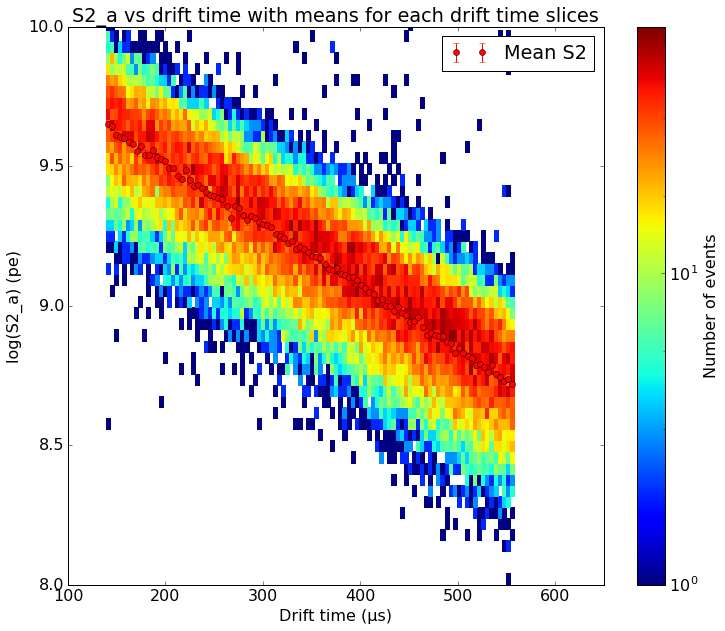

In [402]:
# Error bar : standard deviation / sqrt(N)

drift_time= df2['int_a_drift_time']/1000
s2_a= np.log(df2['s2_a'])

h = Histdd(drift_time, s2_a, bins=(100, 200), #Mean calculate on each bins
           axis_names=['drift_time', 's2_a'])

dt = h.bin_centers('drift_time')
ms2_a = h.average('s2_a').histogram
std_error_s2_a = (h.std(axis='s2_a') / np.sqrt(h.sum('s2_a'))).histogram # std : Compute the standard deviation along the specified axis

h.plot(log_scale=True, cblabel='Number of events')
plt.errorbar(dt, ms2_a, yerr=std_error_s2_a,
             marker='o', linestyle='', color='red',
             label='Mean S2')
plt.xlabel('Drift time (µs)')
plt.ylabel('log(S2_a) (pe)')
plt.ylim(8,10)
plt.xlim(100,650)
plt.legend()
plt.title("S2_a vs drift time with means for each drift time slices")
plt.show()

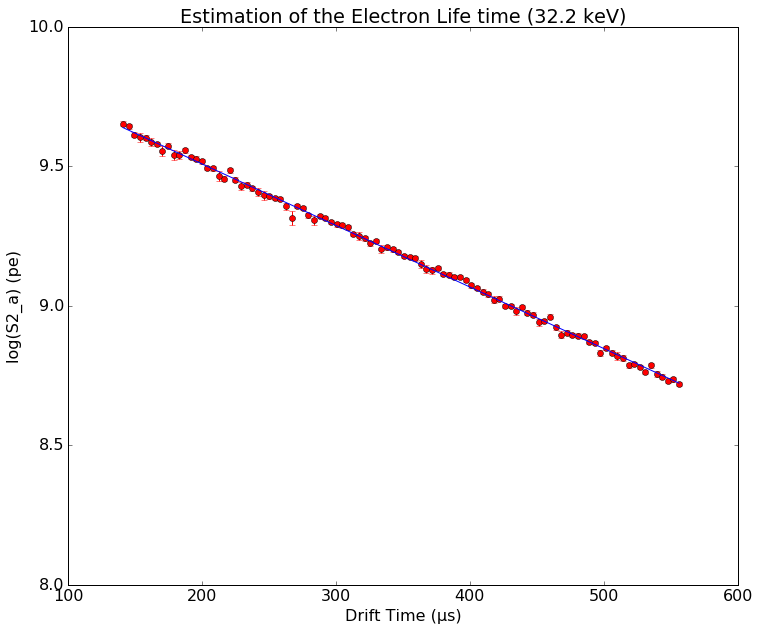

Electron Life time=  453.381481134 µs


In [403]:
fit_s2_a = np.polyfit(dt, ms2_a, deg=1)
plt.plot()
plt.errorbar(dt,ms2_a, yerr=std_error_s2_a,
             marker='o', linestyle='', color='red',
             label='Mean S2_a')
plt.plot(dt, fit_s2_a[0] * dt + fit_s2_a[1], color='blue', label="Fit")
plt.xlim(100,600)
plt.ylim(8,10)
plt.title('Estimation of the Electron Life time (32.2 keV)')
plt.xlabel('Drift Time (µs)')
plt.ylabel('log(S2_a) (pe)')
plt.show()

print("Electron Life time= ", -1/(fit_s2_a[0]) , 'µs')


# Conclusion

The code works quite well, but I don't get the same values as Sara did in this note https://xecluster.lngs.infn.it/dokuwiki/doku.php?id=xenon:xenon1t:sara:kr83m_november (for the same dataset: Nov 2017). 

Sara's values: 
- Light yield at 32.2 keV : 5.54 $\pm$ 0.01 PE/keV
- Light yield at 9.4 keV : 6.96 $\pm$ 0.02 PE/keV

My values : 
- Light yield at 32.2 keV : 7.30 PE/keV
- Light yield at 9.4 keV : 9.00 PE/keV

It's probably due to the fact that the pax version changed (Sara used data processed with pax_v6.1.0, I used pax_v6.5.0)

The second "method" to extract Light Yield and Electron Live time are more efficient and have the advantage of determining the error bars. 